# Resources

- https://www.cs.ubc.ca/~schmidtm/Courses/340-F15/L31.pdf
- https://en.wikipedia.org/wiki/Spectral_clustering
- https://en.wikipedia.org/wiki/Laplacian_matrix
- https://towardsdatascience.com/spectral-clustering-for-beginners-d08b7d25b4d8
- http://blog.shriphani.com/2015/04/06/the-smallest-eigenvalues-of-a-graph-laplacian/

# Import 

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from scipy.stats import norm, multivariate_normal
from SimPEG.utils import mkvc
from sklearn import datasets
from sklearn.cluster import KMeans
import scipy.sparse as sp

In [6]:
# example dataset
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)

Text(0.5, 1.0, 'TRUE CLASSIFICATION')

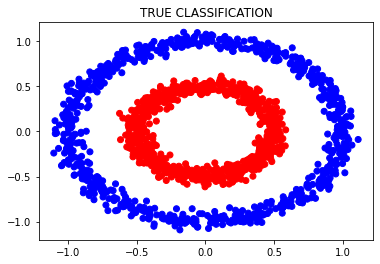

In [106]:
plt.scatter(noisy_circles[0][:,0],noisy_circles[0][:,1],c=noisy_circles[1],cmap='bwr')
plt.gca().set_title('TRUE CLASSIFICATION')

# Build the Matrices

## Adjacency Matrix

In [70]:
data_subset_for_test = noisy_circles[0]

In [71]:
tree = KDTree(data_subset_for_test)

In [76]:
kneighbors = 10

In [77]:
knearest, kindx = tree.query(data_subset_for_test,k=kneighbors+1)

In [78]:
kindx = kindx[:,1:]

In [79]:
kindx

array([[1152,  544,  174, ...,  652,  362,  761],
       [ 672, 1491,  948, ..., 1097,  704,  383],
       [1027,  367,  696, ...,  943,   85,  604],
       ...,
       [1225, 1096,  962, ..., 1471,  647,  887],
       [1123,  255,  913, ..., 1286,  814,  539],
       [1408,  573,  978, ...,  896,  645,  447]])

In [80]:
# build sparse adjacency matrix
A = sp.lil_matrix((data_subset_for_test.shape[0],data_subset_for_test.shape[0]))

In [81]:
A[:,kindx] = 1.

In [97]:
eigenvalues,eigenvectors = sp.linalg.eigs(A,k=2)
eigenvalues,eigenvectors = eigenvalues.real,eigenvectors.real

In [101]:
eigenvectors.shape

(1500, 2)

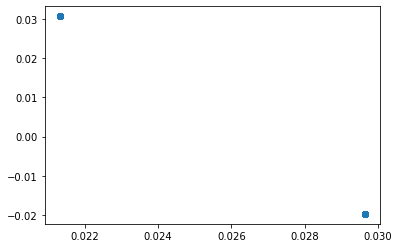

In [102]:
plt.scatter(eigenvectors[:,0],eigenvectors[:,1])

In [103]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(eigenvectors)

In [104]:
kmeans.labels_

array([1, 0, 1, ..., 0, 1, 1], dtype=int32)

Text(0.5, 1.0, 'SPECTRAL CLUSTERING CLASSIFICATION PREDICTION')

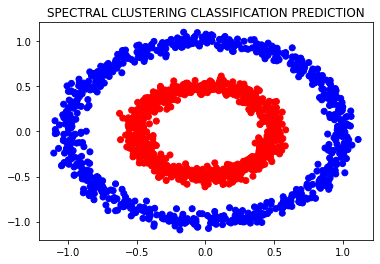

In [107]:
plt.scatter(noisy_circles[0][:,0],noisy_circles[0][:,1],c=kmeans.labels_,cmap='bwr')
plt.gca().set_title('SPECTRAL CLUSTERING CLASSIFICATION PREDICTION')